2017

Machine Learning Practical

University of Edinburgh

Georgios Pligoropoulos - s1687568

Coursework 4 (part 3)

### Imports, Inits, and helper functions

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
jupyterNotebookEnabled = True
plotting = True

In [5]:
coursework, part = 4, 3
saving = True

In [6]:
import sys, os
mlpdir = os.path.expanduser(
    '~/pligor.george@gmail.com/msc_Artificial_Intelligence/mlp_Machine_Learning_Practical/mlpractical'
)
sys.path.append(mlpdir)

In [7]:
from collections import OrderedDict
from __future__ import division
import skopt
from mylibs.jupyter_notebook_helper import show_graph
import datetime
import os
import time
import tensorflow as tf
import numpy as np
from mlp.data_providers import MSD10GenreDataProvider, MSD25GenreDataProvider,\
    MSD10Genre_Autoencoder_DataProvider, MSD10Genre_StackedAutoEncoderDataProvider
import matplotlib.pyplot as plt
%matplotlib inline
from mylibs.batch_norm import fully_connected_layer_with_batch_norm_and_l2
from mylibs.stacked_autoencoder_pretrainer import \
    constructModelFromPretrainedByAutoEncoderStack,\
    buildGraphOfStackedAutoencoder, executeNonLinearAutoencoder
    
from mylibs.jupyter_notebook_helper import getRunTime, getTrainWriter, getValidWriter,\
    plotStats, initStats, gatherStats
    
from mylibs.tf_helper import tfRMSE, tfMSE, fully_connected_layer
    #trainEpoch, validateEpoch

from mylibs.py_helper import merge_dicts

from mylibs.dropout_helper import constructProbs

from mylibs.batch_norm import batchNormWrapper_byExponentialMovingAvg,\
    fully_connected_layer_with_batch_norm
    
import pickle
from skopt.plots import plot_convergence
from mylibs.jupyter_notebook_helper import DynStats
import operator
from skopt.space.space import Integer, Categorical
from skopt import gp_minimize
from rnn.manual_rnn import ManualRNN

In [8]:
seed = 16011984
rng = np.random.RandomState(seed=seed)

In [9]:
config = tf.ConfigProto(log_device_placement=True, allow_soft_placement=True)
config.gpu_options.allow_growth = True

In [10]:
figcount = 0

In [11]:
tensorboardLogdir = 'tf_cw%d_%d' % (coursework, part)

In [12]:
curDtype = tf.float32

In [13]:
reluBias = 0.1

In [14]:
hidden_dims = np.array([500, 500, 25, 10]).astype(int)
hidden_dims

array([500, 500,  25,  10])

In [15]:
batch_size = 50

num_steps = 6 # number of truncated backprop steps ('n' in the discussion above)
#num_classes = 2
state_size = 10      #each state is represented with a certain width, a vector
learningRate = 1e-4 #default of Adam is 1e-3
#momentum = 0.5
#lamda2 = 1e-2

In [16]:
best_params_filename = 'best_params_rnn.npy'

here the state size is equal to the number of classes because we have given to the last output all the responsibility.

We are going to follow a repetitive process. For example if num_steps=6 then we break the 120 segments into 20 parts

The output of each part will be the genre. We are comparing against the genre every little part 

### MSD 10 genre task

In [14]:
segmentCount = 120
segmentLen = 25

In [39]:
def get_dp(which_set, num_steps):
    return MSD10Genre_120_rnn_DataProvider(
        num_steps = num_steps, which_set = which_set, batch_size=batch_size, rng=rng
    )

In [14]:
def trainEpoch(outputs, state_size, init_state, inputs, targets, sess, e, train_data,
               train_step, error, accuracy, extraFeedDict = {}):
    train_error = 0.
    train_accuracy = 0.
    #train_error = []
    #train_accuracy = []
    
    num_batches = train_data.num_batches
    
    zeroState = lambda : np.zeros([batch_size, state_size])
    
    cur_state = zeroState()
    
    for step, ((input_batch, target_batch), segmentPartCounter) in enumerate(train_data):
        cur_state, _, batch_error, batch_acc = sess.run(
            [outputs, train_step, error, accuracy], 
            feed_dict= merge_dicts({inputs: input_batch,
                                    targets: target_batch,
                                    init_state: cur_state}, extraFeedDict)
        )
        
        if (segmentPartCounter + 1) % train_data.segment_part_count == 0:
            cur_state = zeroState()
            #only care about the last output of the training error and acc of the rnn
            #so include it in if-statement
            train_error += batch_error
            train_accuracy += batch_acc
            #train_error.append(batch_error)
            #train_accuracy.append(batch_acc)
    
    train_error /= num_batches
    train_accuracy /= num_batches
    #assert len(train_error) == num_batches
    #assert len(train_accuracy) == num_batches
    #train_error = np.mean(train_error)
    #train_accuracy = np.mean(train_accuracy)
    
    return train_error, train_accuracy

In [15]:
def validateEpoch(outputs, state_size, init_state, inputs, targets, sess, e,
                  valid_data, error, accuracy, extraFeedDict={}):
    valid_error = 0.
    valid_accuracy = 0.
    
    num_batches = valid_data.num_batches
    
    zeroState = lambda : np.zeros([batch_size, state_size])
    
    cur_state = zeroState()
    
    for step, ((input_batch, target_batch), segmentPartCounter) in enumerate(valid_data):
        cur_state, batch_error, batch_acc = sess.run(
            [outputs, error, accuracy], 
            feed_dict= merge_dicts({inputs: input_batch,
                                    targets: target_batch,
                                   init_state: cur_state}, extraFeedDict)
        )
        
        if (segmentPartCounter + 1) % valid_data.segment_part_count == 0:
            cur_state = zeroState()
            #only care about the last output of the training error and acc of the rnn
            #so include it in if-statement
            valid_error += batch_error
            valid_accuracy += batch_acc

    valid_error /= valid_data.num_batches
    valid_accuracy /= valid_data.num_batches
    
    return valid_error, valid_accuracy

In [16]:
def trainAndValidate(train_data, valid_data, state_size, graph, init, outputs, inputs,
                     targets, init_state, train_step, error, accuracy,
                     epochs=35, verbose=True):
    if verbose:
        print "epochs: %d" % epochs
        print "rnn steps: %d" % train_data.num_steps
        print "state size: %d" % state_size

    with tf.Session(graph=graph, config=config) as sess:
        sess.run(init)

        stats, keys = initStats(epochs)

        for e in range(epochs):
            (train_error, train_accuracy), runTime = getRunTime(lambda : 
                    trainEpoch(
                        outputs, state_size, init_state, inputs, targets, sess, e,
                        train_data, train_step, error, accuracy
                    )
            )

            if (e + 1) % 1 == 0:
                valid_error, valid_accuracy = validateEpoch(
                    outputs, state_size, init_state, inputs, targets, sess, e,
                    valid_data, error, accuracy
                )

            if verbose:
                print 'End epoch %02d (%.3f secs): err(train)=%.2f, acc(train)=%.2f, err(valid)=%.2f, acc(valid)=%.2f, ' %\
                    (e+1, runTime, train_error, train_accuracy, valid_error, valid_accuracy)

            stats = gatherStats(e, train_error, train_accuracy,
                                valid_error, valid_accuracy, stats)
    
    if verbose:
        print
    
    return stats, keys

In [6]:
from rnn.msd10_data_providers import MSD10Genre_120_rnn_DataProvider

In [18]:
# a = np.array([np.arange(30), np.arange(30)])
# print a.shape
# print a
# print a.reshape((2, 6, 5))
# b = a.reshape((2, 2, 3, 5))
# print b
# print b[:, 0, :, :]

In [20]:
# train_data = MSD10GenreDataProvider('train', batch_size=batch_size, rng=rng) #((50, 3000), (50, 10))
# valid_data = MSD10GenreDataProvider('valid', batch_size=batch_size, rng=rng)
train_data = get_dp('train', num_steps)
valid_data = get_dp('valid', num_steps)
#((50, 6, 25), (50, 10))

In [24]:
# cell = tf.nn.rnn_cell.BasicRNNCell(state_size)
# rnn_outputs, final_state = tf.nn.rnn(cell, rnn_inputs, initial_state=init_state)

In [25]:
def getGraph(num_steps, train_data):
    graph = tf.Graph() #create new graph

    with graph.as_default():
        with tf.name_scope('data'):
            inputs = tf.placeholder(curDtype, [batch_size, num_steps, segmentLen],
                                   name='input_placeholder')

            targets = tf.placeholder(curDtype, [batch_size, train_data.num_classes],
                                    name='labels_placeholder')

            init_state = tf.placeholder(curDtype, [batch_size, state_size],
                                name='previous_state_placeholder')

        #list where each item have dim 50 x 25
        rnn_inputs = tf.unpack(inputs, axis=1, name='rnn_inputs')

        getRnn_W = lambda : tf.get_variable('W', [segmentLen + state_size, state_size])
        getRnn_b = lambda : tf.get_variable('b', [state_size],
                                            initializer=tf.constant_initializer(0.0))

        with tf.variable_scope('rnn_cell'):
            W = getRnn_W()
            b = getRnn_b()

        def rnn_cell(rnn_input, state):
            with tf.variable_scope('rnn_cell', reuse=True):
                W = getRnn_W()
                b = getRnn_b()

                rnn_cell_out = tf.tanh(tf.matmul(
                    tf.concat(1, [rnn_input, state]), W
                    #concat dimension, inputs, so you see that both the state and the inputs are being treated as one
                ) + b)

            return rnn_cell_out

        state = init_state
        rnn_outputs = []
        for rnn_input in rnn_inputs:
            state = rnn_cell(rnn_input, state)
            rnn_outputs.append(state)

        #as we see here the outputs are the state outputs of each rnn.
        #But here we have set the dimensionality to an arbitrary number of 4, right? so how is this converted back to dim 2?

        outputs = rnn_outputs[-1] #final state

        with tf.name_scope('error'):
            error = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(outputs, targets)
            )

        with tf.name_scope('accuracy'):
            accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1),
                                                       tf.argmax(targets, 1)), dtype=curDtype))

        with tf.name_scope('train'):
            train_step = tf.train.AdamOptimizer(learning_rate=learningRate).minimize(error)

        init = tf.global_variables_initializer()
    
    return graph, init, outputs, inputs, targets, init_state, train_step, error, accuracy

In [26]:
graph, init, outputs, inputs, targets, init_state, train_step, error, accuracy = getGraph(
    num_steps=num_steps, train_data=train_data
)

In [24]:
show_graph(graph)

epochs: 35
rnn steps: 6
state size: 10
End epoch 01 (35.843 secs): err(train)=2.05, acc(train)=0.28, err(valid)=1.93, acc(valid)=0.32, 
End epoch 02 (31.943 secs): err(train)=1.89, acc(train)=0.34, err(valid)=1.88, acc(valid)=0.34, 
End epoch 03 (30.201 secs): err(train)=1.85, acc(train)=0.35, err(valid)=1.86, acc(valid)=0.35, 
End epoch 04 (29.722 secs): err(train)=1.84, acc(train)=0.36, err(valid)=1.85, acc(valid)=0.35, 
End epoch 05 (30.456 secs): err(train)=1.83, acc(train)=0.36, err(valid)=1.84, acc(valid)=0.36, 
End epoch 06 (30.021 secs): err(train)=1.82, acc(train)=0.36, err(valid)=1.84, acc(valid)=0.36, 
End epoch 07 (31.253 secs): err(train)=1.82, acc(train)=0.36, err(valid)=1.83, acc(valid)=0.36, 
End epoch 08 (29.638 secs): err(train)=1.82, acc(train)=0.36, err(valid)=1.83, acc(valid)=0.36, 
End epoch 09 (29.739 secs): err(train)=1.81, acc(train)=0.37, err(valid)=1.83, acc(valid)=0.36, 
End epoch 10 (30.053 secs): err(train)=1.81, acc(train)=0.37, err(valid)=1.83, acc(valid

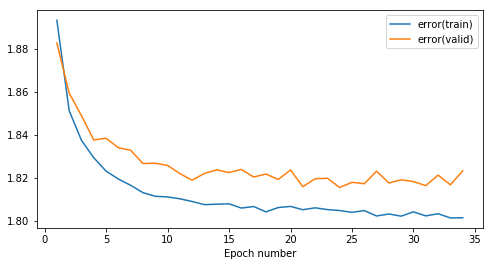

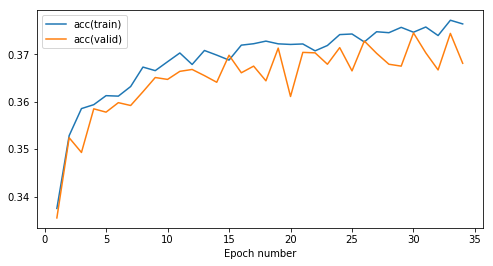

In [25]:
%%time

stats, keys = trainAndValidate(
    train_data, valid_data, state_size, graph, init, outputs, inputs, targets, init_state,
    train_step, error, accuracy
)

if plotting:
    fig_1, ax_1, fig_2, ax_2 = plotStats(stats, keys)
    figcount += 1
    if saving:
        fig_1.savefig('cw%d_part%d_%02d_fig_error.svg' % (coursework, part, figcount))
        fig_2.savefig('cw%d_part%d_%02d_fig_valid.svg' % (coursework, part, figcount))

### Grid search for best rnn number of steps hyperparameter

In [27]:
numLens = np.sort(np.unique([2, 3, 4, 5, 6, 8, 10, 12, 15, 20, 24, 30, 40, 60]))
assert np.all( segmentCount % numLens == 0 )
print len(numLens)
numLens

14


array([ 2,  3,  4,  5,  6,  8, 10, 12, 15, 20, 24, 30, 40, 60])

Estimated grid search < 5 hours

In [28]:
%%time

filename = 'rnn_grid_search.npz'

if not os.path.isfile(filename):
    statsCollection = OrderedDict()
    keysCollection = OrderedDict()

    for num_steps in numLens:
        train_data = get_dp('train', num_steps)
        valid_data = get_dp('valid', num_steps)
        assert train_data.num_steps == valid_data.num_steps == num_steps

        graph, init, outputs, inputs, targets, init_state, train_step, error, accuracy =\
            getGraph(num_steps=num_steps, train_data=train_data)

        stats, keys = trainAndValidate(
            train_data, valid_data, state_size, graph, init, outputs, inputs,
            targets, init_state, train_step, error, accuracy
        )

        statsCollection[num_steps] = stats
        keysCollection[num_steps] = keys

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 23.6 ms


In [29]:
if os.path.isfile(filename):
    loaded = np.load(filename)
    statsCollection, keysCollection = loaded['arr_0'][()], loaded['arr_1'][()]
else:
    np.savez(filename, statsCollection, keysCollection)

In [30]:
maxValidAccs = OrderedDict()
for num_steps in numLens:
    maxValidAccs[num_steps] = np.max(statsCollection[num_steps][
        :, keysCollection[num_steps]['acc(valid)']
    ])

maxValidAccs

OrderedDict([(2, 0.36779998768121003),
             (3, 0.37219998769462109),
             (4, 0.37379998661577701),
             (5, 0.37219998754560946),
             (6, 0.37369998879730704),
             (8, 0.3765999857336283),
             (10, 0.37599998615682123),
             (12, 0.36759998872876165),
             (15, 0.37409998729825023),
             (20, 0.36459998786449432),
             (24, 0.3489999892562628),
             (30, 0.35079998783767224),
             (40, 0.33259998969733717),
             (60, 0.33409998886287212)])

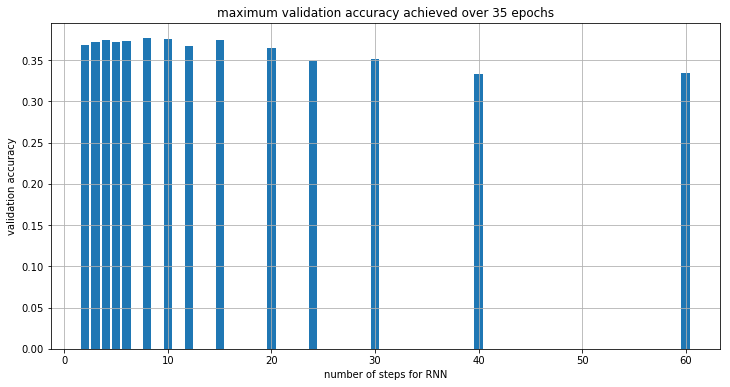

In [31]:
if plotting:
    fig = plt.figure(figsize=(12,6))
    plt.bar(maxValidAccs.keys(), maxValidAccs.values())
    plt.title('maximum validation accuracy achieved over 35 epochs')
    plt.ylabel('validation accuracy')
    plt.xlabel('number of steps for RNN')
    plt.grid()
    plt.show()
    if saving:
        figcount += 1
        fig.savefig('cw%d_part%d_%02d_fig.svg' % (coursework, part, figcount))

In [32]:
print "number of steps where maximum validation accuracy was achieved"
bestNumSteps = maxValidAccs.keys()[np.argmax(maxValidAccs.values())]
bestNumSteps

number of steps where maximum validation accuracy was achieved


8

In [33]:
#highValidAccs 
#np.sort(maxValidAccs.values())[::-1]
highValidAccs = sorted(maxValidAccs.items(), key=operator.itemgetter(1))[::-1]
#highValidAccs[:7]
highValidAccs = OrderedDict(highValidAccs[:7])
highValidAccs

OrderedDict([(8, 0.3765999857336283),
             (10, 0.37599998615682123),
             (15, 0.37409998729825023),
             (4, 0.37379998661577701),
             (6, 0.37369998879730704),
             (3, 0.37219998769462109),
             (5, 0.37219998754560946)])

In [34]:
def renderCollection(title, k, figcount):
    fig = plt.figure(figsize=(12,6))

    for num_steps in numLens:
        label = 'num steps %d' % num_steps
        stats = statsCollection[num_steps]
        keys = keysCollection[num_steps]
        if num_steps in highValidAccs.keys():
            plt.plot(np.arange(1, stats.shape[0]),
                     stats[1:, keys[k]], label=label)
        else:
            plt.plot(np.arange(1, stats.shape[0]),
                         stats[1:, keys[k]], c='lightgrey')
        plt.hold(True)

    plt.hold(False)
    plt.legend(loc=0)
    plt.title(title + ' over 35 epochs')
    plt.xlabel('Epoch number')
    plt.ylabel(title)
    plt.grid()
    plt.show()
    
    if saving:
        figcount += 1
        fig.savefig('cw%d_part%d_%02d_fig.svg' % (coursework, part, figcount))

/home/studenthp/anaconda2/envs/mlp/lib/python2.7/site-packages/ipykernel/__main__.py:14: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/home/studenthp/anaconda2/envs/mlp/lib/python2.7/site-packages/ipykernel/__main__.py:16: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


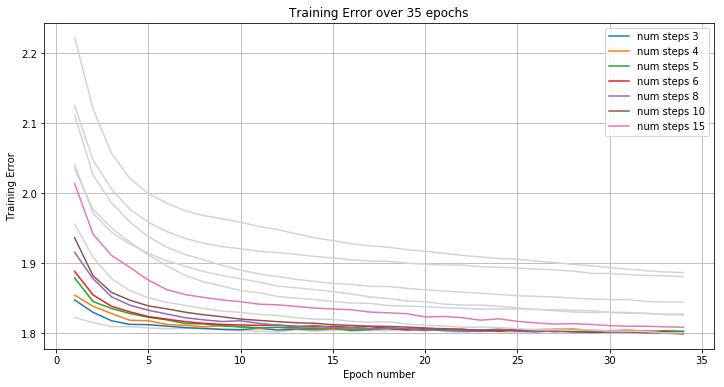

In [37]:
figcount += 1
renderCollection(title='Training Error', k = 'error(train)', figcount=figcount)

/home/studenthp/anaconda2/envs/mlp/lib/python2.7/site-packages/ipykernel/__main__.py:14: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/home/studenthp/anaconda2/envs/mlp/lib/python2.7/site-packages/ipykernel/__main__.py:16: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


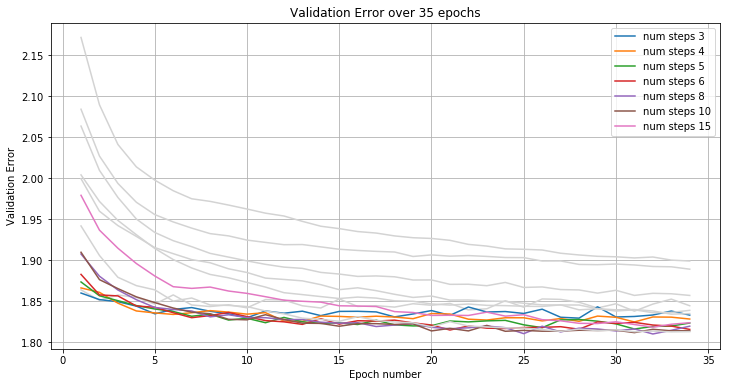

In [38]:
figcount += 1
renderCollection(title='Validation Error', k = 'error(valid)', figcount=figcount)

/home/studenthp/anaconda2/envs/mlp/lib/python2.7/site-packages/ipykernel/__main__.py:14: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/home/studenthp/anaconda2/envs/mlp/lib/python2.7/site-packages/ipykernel/__main__.py:16: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


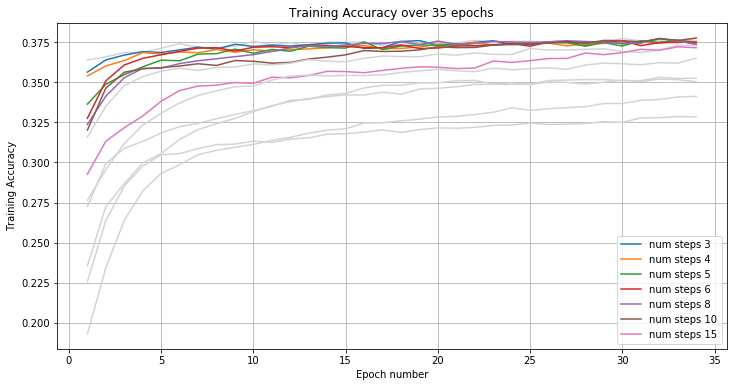

In [39]:
figcount += 1
renderCollection(title='Training Accuracy', k = 'acc(train)', figcount=figcount)

/home/studenthp/anaconda2/envs/mlp/lib/python2.7/site-packages/ipykernel/__main__.py:14: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/home/studenthp/anaconda2/envs/mlp/lib/python2.7/site-packages/ipykernel/__main__.py:16: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


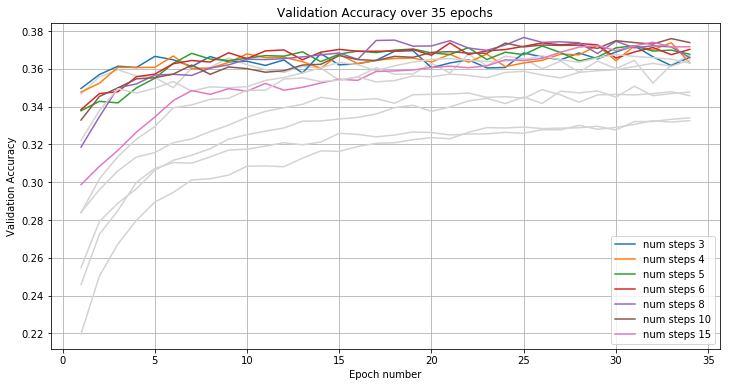

In [40]:
figcount += 1
renderCollection(title='Validation Accuracy', k = 'acc(valid)', figcount=figcount)

### Exploration of best state size and best num of steps RNN with Bayesian Optimization
We see that validation accuracy was not high but neither was training error so we might have a small complexity in our model. We need to explore larger dimensionality for the state size of our RNN

In [40]:
numLens = np.sort(np.unique([2, 3, 4, 5, 6, 8, 10, 12, 15, 20, 24, 30, 40, 60]))
assert np.all( segmentCount % numLens == 0 )
print len(numLens)
numLens

14


array([ 2,  3,  4,  5,  6,  8, 10, 12, 15, 20, 24, 30, 40, 60])

In [16]:
manualRNN = ManualRNN(batch_size=batch_size, rng=rng, dtype = curDtype, config=config,
                      segment_count=segmentCount, segment_len= segmentLen)

In [20]:
#same as before
show_graph(manualRNN.getGraph(num_steps=8, state_size=20))
#del train_data

In [23]:
#it cannot accept global variables for some unknown reason ...
def objective(params): # Here we define the metric we want to minimise    
    (state_size, num_steps) = params
    
    train_data = get_dp('train', num_steps)
    valid_data = get_dp('valid', num_steps)
    print train_data.num_steps
    assert train_data.num_steps == valid_data.num_steps == num_steps
    
    graph, init, outputs, inputs, targets, init_state, train_step, error, accuracy =\
        getGraph(num_steps=num_steps, train_data=train_data, state_size=state_size)
    
    stats, keys = trainAndValidate(
        train_data, valid_data, state_size, graph, init, outputs, inputs,
        targets, init_state, train_step, error, accuracy, epochs = 25
    )
    
    #save everytime in case it crashes
    filename = 'rnn_bay_opt_stateSpace_numSteps_statsCollection.npy'
    statsCollection = np.load(filename)[()] if os.path.isfile(filename) else dict()
    statsCollection[(state_size, num_steps)] = stats
    np.save(filename, statsCollection)
    
    if plotting:
        fig_1, ax_1, fig_2, ax_2 = plotStats(stats, keys)
        plt.show()
    
    # We want to maximise validation accuracy, i.e. minimise minus validation accuracy
    validAccs = stats[:, -1]
    length10percent = len(validAccs) // 10
    best10percent = np.sort(validAccs)[-length10percent:]
    return -np.mean(best10percent)
    #return -max(stats[:, -1])

In [24]:
stateSizeSpace = Integer(15, 500)
numStepSpace = Categorical(numLens)
space  = [stateSizeSpace, numStepSpace]
#space  = [stateSizeSpace]

In [45]:
%%time

if not os.path.isfile(best_params_filename):
    res_gp = gp_minimize(
            func=objective, # function that we wish to minimise
            dimensions=space, #the search space for the hyper-parameters
            #x0=x0, #inital values for the hyper-parameters
            n_calls=25, #number of times the function will be evaluated
            random_state = seed, #random seed
            n_random_starts=1,
                #before we start modelling the optimised function with a GP Regression
                #model, we want to try a few random choices for the hyper-parameters.
            kappa=1.9 #trade-off between exploration vs. exploitation.
    )

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 120 µs


In [46]:
if os.path.isfile(best_params_filename):
    best_params = np.load(best_params_filename)
else:
    np.save(best_params_filename, res_gp.x)
    best_params = res_gp.x

In [47]:
res_gp_save_filename = 'res_gp_rnn.pickle'
if os.path.isfile(res_gp_save_filename):
    with open(res_gp_save_filename) as f:  # Python 3: open(..., 'rb')
        (res_gp, ) = pickle.load(f)
else:
    with open(res_gp_save_filename, 'w') as f:  # Python 3: open(..., 'wb')
        pickle.dump([res_gp], f)

AttributeError: 'module' object has no attribute 'objective'

In [48]:
best_params

array([341,   4])

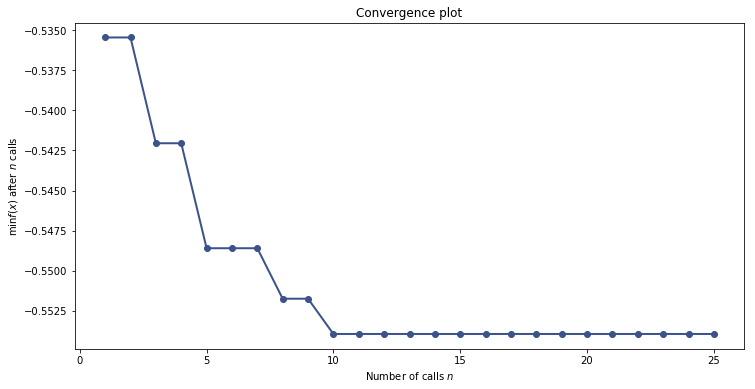

In [30]:
if plotting:
    fig = plt.figure(figsize=(12,6))
    plot_convergence(res_gp)
    plt.grid()
    plt.show()
    if saving:
        figcount += 1
        fig.savefig('cw%d_part%d_%02d_fig.svg' % (coursework, part, figcount))

In [37]:
figcount = 20

/home/studenthp/anaconda2/envs/mlp/lib/python2.7/site-packages/ipykernel/__main__.py:3: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  app.launch_new_instance()
/home/studenthp/anaconda2/envs/mlp/lib/python2.7/site-packages/ipykernel/__main__.py:9: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


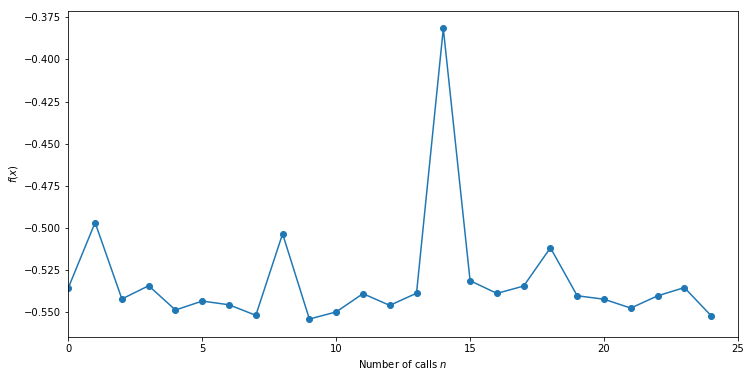

In [38]:
if plotting:
    fig = plt.figure(figsize=(12,6))
    plt.hold(True)
    plt.plot(res_gp.func_vals)
    plt.scatter(range(len(res_gp.func_vals)), res_gp.func_vals)
    plt.ylabel(r'$f(x)$')
    plt.xlabel('Number of calls $n$')
    plt.xlim([0, len(res_gp.func_vals)])
    plt.hold(False)
    plt.show()
    if saving:
        figcount += 1
        fig.savefig('cw%d_part%d_%02d_fig.svg' % (coursework, part, figcount))

### Plotting all

In [21]:
filename = 'rnn_bay_opt_stateSpace_numSteps_statsCollection.npy'

In [22]:
statsCollection = np.load(filename)
print statsCollection.shape
statsCollection = statsCollection[()]

()


In [23]:
print len(statsCollection)
statsCollection.keys()

20


[(261, 4),
 (118, 2),
 (363, 4),
 (323, 3),
 (321, 12),
 (500, 24),
 (325, 6),
 (15, 30),
 (500, 20),
 (325, 4),
 (321, 4),
 (365, 5),
 (341, 4),
 (500, 12),
 (323, 60),
 (500, 40),
 (324, 4),
 (340, 4),
 (322, 4),
 (349, 15)]

In [42]:
maxValidAccs = OrderedDict([
    (key, max(val[:, -1])) for key, val in statsCollection.iteritems()
])
maxValidAccs

OrderedDict([((261, 4), 0.53539997905492787),
             ((118, 2), 0.49829998299479483),
             ((363, 4), 0.54339998185634608),
             ((323, 3), 0.54149998411536215),
             ((321, 12), 0.53979998081922531),
             ((500, 24), 0.53199998274445537),
             ((325, 6), 0.55219998210668564),
             ((15, 30), 0.38309998922049998),
             ((500, 20), 0.536499984562397),
             ((325, 4), 0.53809998482465748),
             ((321, 4), 0.54459998354315753),
             ((365, 5), 0.53809998229146005),
             ((341, 4), 0.53979998141527175),
             ((500, 12), 0.55439998328685758),
             ((323, 60), 0.51239998146891597),
             ((500, 40), 0.50539998210966586),
             ((324, 4), 0.54249998182058334),
             ((340, 4), 0.54669998228549954),
             ((322, 4), 0.55629998311400408),
             ((349, 15), 0.55669998362660411)])

In [43]:
#np.argsort(statsCollection)
highValidAccs = sorted(maxValidAccs.items(), key=operator.itemgetter(1))[::-1]
highValidAccs = OrderedDict(highValidAccs[:7])
highValidAccs

OrderedDict([((349, 15), 0.55669998362660411),
             ((322, 4), 0.55629998311400408),
             ((500, 12), 0.55439998328685758),
             ((325, 6), 0.55219998210668564),
             ((340, 4), 0.54669998228549954),
             ((321, 4), 0.54459998354315753),
             ((363, 4), 0.54339998185634608)])

In [45]:
def renderStatsCollection(statsCollection, title, k, figcount):
    fig = plt.figure(figsize=(12,6))

    for key in statsCollection:
        label = 'state size: %d, num steps: %d' % key
        stats = statsCollection[key]
        keys = DynStats.keys
        xValues = np.arange(1, stats.shape[0])
        yValues = stats[1:, keys[k]]
        
        if key in highValidAccs.keys():
            plt.plot(xValues, yValues, label=label)
        else:
            plt.plot(xValues, yValues, c='lightgrey')
        plt.hold(True)

    plt.hold(False)
    plt.legend(loc=0)
    plt.title(title + ' over 25 epochs')
    plt.xlabel('Epoch number')
    plt.ylabel(title)
    plt.grid()
    plt.show()
    
    if saving:
        fig.savefig('cw%d_part%d_%02d_fig.svg' % (coursework, part, figcount))

/home/studenthp/anaconda2/envs/mlp/lib/python2.7/site-packages/ipykernel/__main__.py:15: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/home/studenthp/anaconda2/envs/mlp/lib/python2.7/site-packages/ipykernel/__main__.py:17: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


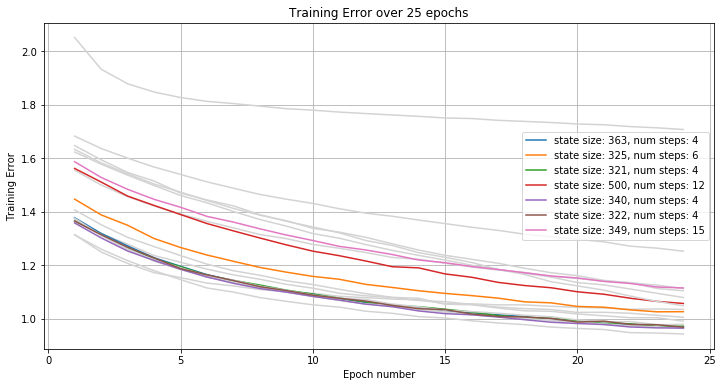

In [46]:
figcount += 1
renderStatsCollection(statsCollection, "Training Error", "error(train)", figcount)

/home/studenthp/anaconda2/envs/mlp/lib/python2.7/site-packages/ipykernel/__main__.py:15: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/home/studenthp/anaconda2/envs/mlp/lib/python2.7/site-packages/ipykernel/__main__.py:17: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


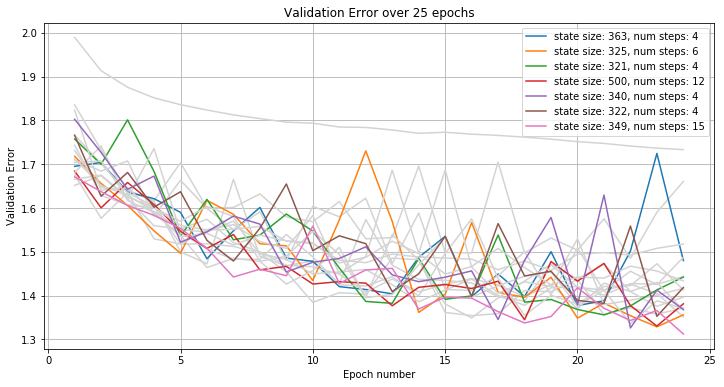

In [47]:
figcount += 1
renderStatsCollection(statsCollection, "Validation Error", "error(valid)", figcount)

/home/studenthp/anaconda2/envs/mlp/lib/python2.7/site-packages/ipykernel/__main__.py:15: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/home/studenthp/anaconda2/envs/mlp/lib/python2.7/site-packages/ipykernel/__main__.py:17: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


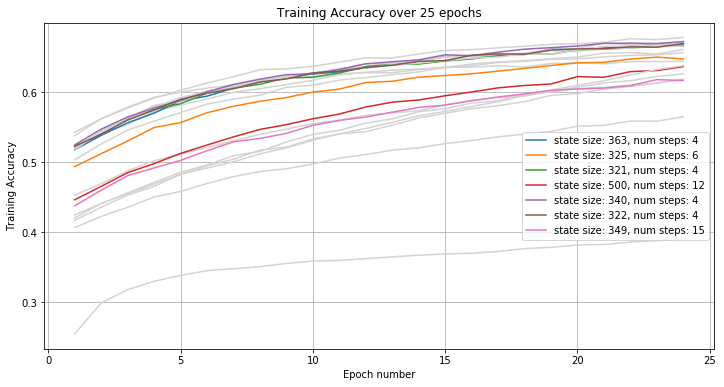

In [48]:
figcount += 1
renderStatsCollection(statsCollection, "Training Accuracy", "acc(train)", figcount)

/home/studenthp/anaconda2/envs/mlp/lib/python2.7/site-packages/ipykernel/__main__.py:15: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/home/studenthp/anaconda2/envs/mlp/lib/python2.7/site-packages/ipykernel/__main__.py:17: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


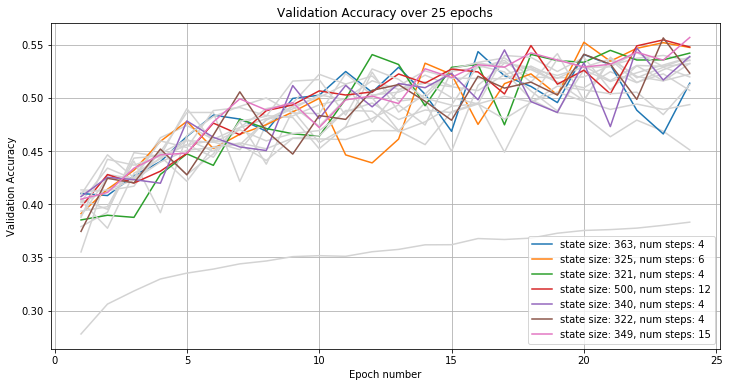

In [49]:
figcount += 1
renderStatsCollection(statsCollection, "Validation Accuracy", "acc(valid)", figcount)

### Experiment with Best Parameters

In [18]:
best_params = np.load(best_params_filename)
best_params

array([341,   4])

In [20]:
manualRNN = ManualRNN(batch_size=batch_size, rng=rng, dtype = curDtype, config=config,
                      segment_count=segmentCount, segment_len= segmentLen)

In [22]:
%%time

(state_size, num_steps) = best_params

stats, keys = manualRNN.run_rnn(state_size = state_size, num_steps=num_steps, epochs = 50)

if plotting:
    fig_1, ax_1, fig_2, ax_2 = plotStats(stats, keys)
    plt.show()
    if saving:
        figcount += 1
        fig_1.savefig('cw%d_part%d_%02d_fig_error.svg' % (coursework, part, figcount))
        fig_2.savefig('cw%d_part%d_%02d_fig_valid.svg' % (coursework, part, figcount))

print max(stats[:, -1]) #maximum validation accuracy

epochs: 50
rnn steps: 4
state size: 341
End epoch 01 (87.347 secs): err(train)=1.45, acc(train)=0.49, err(valid)=1.92, acc(valid)=0.33, 
End epoch 02 (88.386 secs): err(train)=1.36, acc(train)=0.53, err(valid)=1.71, acc(valid)=0.40, 
End epoch 03 (90.924 secs): err(train)=1.30, acc(train)=0.55, err(valid)=1.88, acc(valid)=0.38, 
End epoch 04 (89.690 secs): err(train)=1.26, acc(train)=0.56, err(valid)=1.61, acc(valid)=0.44, 
End epoch 05 (95.919 secs): err(train)=1.21, acc(train)=0.58, err(valid)=1.55, acc(valid)=0.47, 


KeyboardInterrupt: 